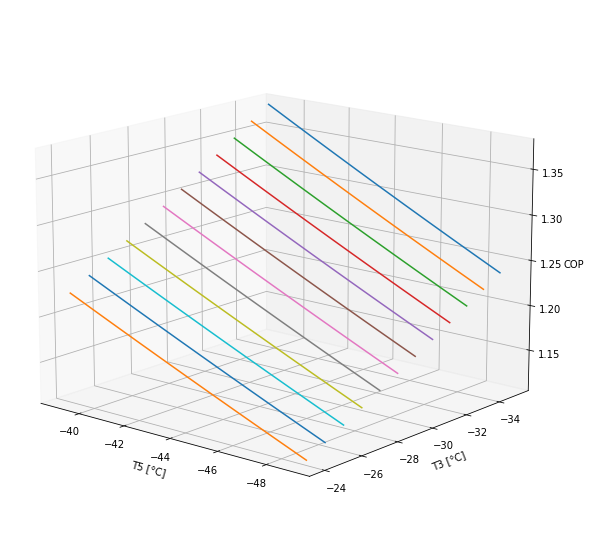

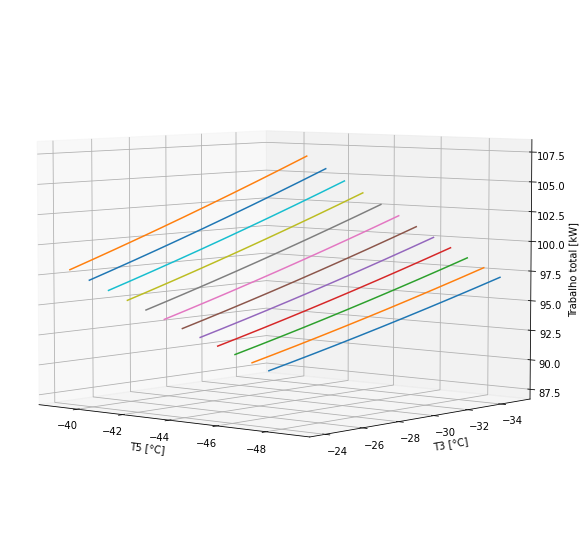

In [10]:
#Bibliotecas
from CoolProp.CoolProp import PropsSI as CP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Listas
T3_lista = []
T5_lista = []
Wcomp_total_lista = []
COP_lista = []
cont = []

for i in range (-49, -38, 1):
    cont.append(i+273.15)

#Dados do problema
Pfrig = 120 * 1000 #[W]
T1 = -80 + 273.15 #[K]
T7 = -8 + 273.15 #[K]
T9 = -12 + 273.15 #[K]
T11 = 35 + 273.15 #[K]
fluid_high = 'R717'
fluid_medium = 'R744'
fluid_low = 'R41'
n = 1.1
drop_suc = 12000 #[Pa]
drop_desc = 24000 #[Pa]

#Pressão crítica do fluido superior
P_crit_high = CP('PCRIT', fluid_high)

#Ciclo inferior
P1 = CP('P', 'T', T1, 'Q', 1, fluid_low) 
h1 = CP('H', 'T', T1, 'Q', 1, fluid_low)
ha = h1
Pa = P1 - drop_suc
Ta = CP('T', 'H', ha, 'P', Pa, fluid_low)
Pb = Pa
Tb = Ta + 4 #superaquecimento de 4°C na admissão
vb = 1 / CP('D', 'T', Tb, 'P', Pb, fluid_low)

#Ciclo intermediário
P7 = CP('P', 'T', T7, 'Q', 0, fluid_medium)
P6 = P7
Py = P6 + drop_desc
h7 = CP('H', 'T', T7, 'Q', 0, fluid_medium)
h8 = h7

#Ciclo superior
P9 = CP('P', 'T', T9, 'Q', 1, fluid_high)
h9 = CP('H', 'T', T9, 'Q', 1, fluid_high)
he = h9
Pe = P9 - drop_suc
Te = CP('T', 'H', he, 'P', Pe, fluid_high)
Pf = Pe
Tf = Te + 4 #superaquecimento de 4°C na admissão
vf = 1 / CP('D', 'T', Tf, 'P', Pf, fluid_high)
P11 = CP('P', 'T', T11, 'Q', 0, fluid_high)
P10 = P11
Pg = P10 + drop_desc
h11 = CP('H', 'T', T11, 'Q', 0, fluid_high)
h12 = h11

#Loop nos três ciclos - variação das temperaturas de evaporação e condensação
for T3 in range (-35, -23, 1):
    #Ciclo inferior
    T3 = T3 + 273.15
    P3 = CP('P', 'T', T3, 'Q', 0 , fluid_low)
    P2 = P3
    Pc = P2 + drop_desc
    h3 = CP('H', 'T', T3, 'Q', 0, fluid_low)
    h4 = h3
    m_flow_low = Pfrig / (h1 - h4)
    vc = (Pb * vb ** n / Pc)**(1 / n)
    hc = CP('H', 'P', Pc, 'D', 1 / vc, fluid_low)
    h2 = hc
    #Trabalho específico do compressor do ciclo inferior
    w_low = n / (n-1) * Pb * vb * ((Pc/Pb)**((n-1)/n) - 1)
    #Trabalho do compressor do ciclo inferior
    Wcomp_low = m_flow_low * w_low
    #Calor trocado no trocador entre o ciclo inferior e o intermediário
    Qcond_low =  m_flow_low * (h2 - h3)
    #Ciclo intermediário
    for T5 in cont:
        P5 = CP('P', 'T', T5, 'Q', 1, fluid_medium)
        h5 = CP('H', 'T', T5, 'Q', 1, fluid_medium)
        hw = h5
        Pw = P5 - drop_suc
        Tw = CP('T', 'H', hw, 'P', Pw, fluid_medium)
        Px = Pw
        Tx = Tw + 4 #superaquecimento de 4°C na admissão
        vx = 1 / CP('D', 'T', Tx, 'P', Px, fluid_medium)
        Qevap_medium = Qcond_low
        m_flow_medium = Qevap_medium / (h5 - h8)
        vy = (Px * vx ** n / Py)**(1 / n)
        hy = CP('H', 'P', Py, 'D', 1 / vy, fluid_medium)
        h6 = hy
        #Trabalho específico do compressor do ciclo intermediário
        w_medium = n / (n-1) * Px * vx * ((Py/Px)**((n-1)/n) - 1)
        #Trabalho no compressor do ciclo intermediário
        Wcomp_medium = m_flow_medium * w_medium
        #Calor trocado no trocador entre o ciclo intermediário e o superior
        Qcond_medium = m_flow_medium * (h6 - h7)
        #Ciclo superior
        Qevap_high = Qcond_medium
        m_flow_high = Qevap_high / (h9 - h12)
        vg = (Pf * vf ** n / Pg)**(1 / n)
        #Verificação da pressão crítica
        if P_crit_high > P10:
            T3_lista.append(T3 - 273.15)
            T5_lista.append(T5 - 273.15)
            #Trabalho específico do compressor do ciclo superior
            w_high = n / (n-1) * Pf * vf * ((Pg/Pf)**((n-1)/n) - 1)
            #Trabalho no compressor do ciclo superior
            Wcomp_high = m_flow_high * w_high
            #Trabalho total do ciclo
            Wcomp_total = Wcomp_low + Wcomp_medium + Wcomp_high
            Wcomp_total_lista.append(Wcomp_total / 1000)
            #COP
            COP = Pfrig / Wcomp_total
            COP_lista.append(COP)
        else:
            print ('A pressão P10 = {:0.2f} kPa (T3 = {:0.2f}°C, T5 = {:0.2f}°C) é maior do que a ' 
               'pressão crítica do {} e, por isso, o ponto não foi incluído no gráfico'
                   .format(P10/1000,T3-273.15,T5-273.15,fluid_high))

if len(T3_lista) !=0:
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1, projection ='3d')
    for i in range (0, len(COP_lista), len(cont)):
        x1line = []
        y1line = []
        z1line = []
        for j in range (i, i + len(cont), 1):
            y1line.append(T3_lista[i])
            x1line.append(T5_lista[j])
            z1line.append (COP_lista[j])
        ax.set_xlabel('T5 [°C]', size = 10)
        ax.set_ylabel('T3 [°C]', size = 10)
        ax.set_zlabel('COP', size = 10)
        ax.view_init(15, 130)
        ax.plot3D(x1line, y1line, z1line)
    plt.show()
else:
    print ('Todos os pontos são inválidos')
    
if len(T3_lista) !=0:
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1, projection ='3d')
    for i in range (0, len(Wcomp_total_lista), len(cont)):
        x1line = []
        y1line = []
        z1line = []
        for j in range (i, i + len(cont), 1):
            y1line.append(T3_lista[i])
            x1line.append(T5_lista[j])
            z1line.append (Wcomp_total_lista[j])
        ax.set_xlabel('T5 [°C]', size = 10)
        ax.set_ylabel('T3 [°C]', size = 10)
        ax.set_zlabel('Trabalho total [kW]', size = 10)
        ax.view_init(5, 130)
        ax.plot3D(x1line, y1line, z1line)
    plt.show()
else:
    print ('Todos os pontos são inválidos')
